# **Jigsaw Unintended Bias: Final Solution**

# **Contents**
### 1. Basic Data Processing (Data Splitting, Tokenization, Padding, Build Embedding Matrix)
### 2. Define Functions to compute Custom Metric
### 3. Model Experimentation (Try out Models with different architectures, loss functions, weighting, train set)
### 4. Summary
### 5. Conclusion
### 6. References

In [1]:
#import dependencies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import model_from_json
from tensorflow.keras import regularizers, initializers, constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Add, Concatenate
from tensorflow.keras.layers import  SpatialDropout1D, Dropout, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from tqdm import tqdm 
import random
import datetime
import gc
import pickle
import sys
import os
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#**1. Basic Data Processing**

## **1.1 Toxicity and Identity Data**

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/train.csv')
train.rename(columns = {'target':'target_cont'}, inplace=True)
print('Shape:', train.shape)
train.head()

Shape: (1804874, 45)


,id,target_cont,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
toxicity_feat = ['target_cont','severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
identity_main = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',  'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [ ]:
toxicity_data = train[toxicity_feat]
identity_data = train[identity_main+['target_cont']]

toxicity_data.to_csv('/content/gdrive/MyDrive/Jigsaw Files/toxicity_data.csv', index=False)
identity_data.to_csv('/content/gdrive/MyDrive/Jigsaw Files/identity_data.csv', index=False)

##**1.2 Word Embeddings**

In [ ]:
!wget --header="Host: downloads.cs.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://nlp.stanford.edu/" --header="Cookie: _ga=GA1.2.2010438444.1670710250; _gid=GA1.2.912510019.1670937715; _gat=1" --header="Connection: keep-alive" "https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip" -c -O 'glove.840B.300d.zip'

--2023-01-04 01:28:04--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  4.98MB/s    in 6m 49s  

2023-01-04 01:34:54 (5.07 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]



In [ ]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [ ]:
def embed2dict(path, name, to_pickle=False):
    print('Indexing word vectors.')
    embedding = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                vector = np.array(values[1:], dtype='float32')
            except:                                                                
                pass
            embedding[word] = vector
    print('Found %s word vectors.' % len(embedding))
    if to_pickle:
        pickle.dump(embedding, open(f"/content/gdrive/MyDrive/Jigsaw Files/{name}.pkl", "wb"))
    return embedding

In [ ]:
glove = embed2dict(path='glove.840B.300d.txt', name = 'glove840B', to_pickle = True)

Indexing word vectors.
Found 2195884 word vectors.


In [ ]:
glove = pickle.load(open('/content/gdrive/MyDrive/Jigsaw Files/glove840B.pkl','rb'))

##**1.3 Tokenization & Padding**

In [ ]:
train_pre = pd.read_pickle('/content/gdrive/MyDrive/Jigsaw Files/preprocessed_train.pkl')
print('Shape:',train_pre.shape)
train_pre.head()

Shape: (1804874, 3)


,target,comment_text,preprcsd
0,0,"This is so cool. It's like, 'would you want yo...",cool like would want mother read really great ...
1,0,Thank you!! This would make my life a lot less...,thank would make life lot less anxiety induce ...
2,0,This is such an urgent design problem; kudos t...,urgent design problem kudos take impressive
3,0,Is this something I'll be able to install on m...,something able install site release
4,1,haha you guys are a bunch of losers.,haha guy bunch loser


In [ ]:
test_pre = pd.read_pickle('/content/gdrive/MyDrive/Jigsaw Files/preprocessed_test.pkl')
print('Shape:',test_pre.shape)
test_pre.head()

Shape: (97320, 2)


,comment_text,preprcsd
0,[ Integrity means that you pay your debts.]\n\...,integrity mean pay debt apply president trump
1,This is malfeasance by the Administrator and t...,malfeasance administrator board waste money
2,@Rmiller101 - Spoken like a true elitist. But ...,speak like true elitist look bud awaken europe...
3,"Paul: Thank you for your kind words. I do, in...",paul thank kind word indeed strong belief not ...
4,Sorry you missed high school. Eisenhower sent ...,sorry miss high school eisenhower send troop v...


In [ ]:
#Stratified Splitting
X_train, X_val, y_train, y_val = train_test_split(train_pre['preprcsd'].values, train_pre['target'].values, test_size=0.2, stratify = train_pre['target'].values, random_state=42)
X_test = test_pre['preprcsd']

In [ ]:
#Tokenisation
tok = Tokenizer() 
tok.fit_on_texts(X_train)
word_index = tok.word_index
pickle.dump(word_index, open('/content/gdrive/MyDrive/Jigsaw Files/Data Split/word_index.pkl', 'wb'))

X_train_seq = tok.texts_to_sequences(X_train)
X_val_seq = tok.texts_to_sequences(X_val)
X_test_seq = tok.texts_to_sequences(X_test)

In [ ]:
comments_vocab = set(word_index.keys())
glove_vocab = set(glove.keys())
print('Unique Words in Comment Data:',len(comments_vocab))
print(f"Vocabulary Coverage: {round(len(comments_vocab.intersection(glove_vocab))/len(comments_vocab)*100, 2)}%")

Unique Words in Comment Data: 216850
Vocabulary Coverage: 55.95%


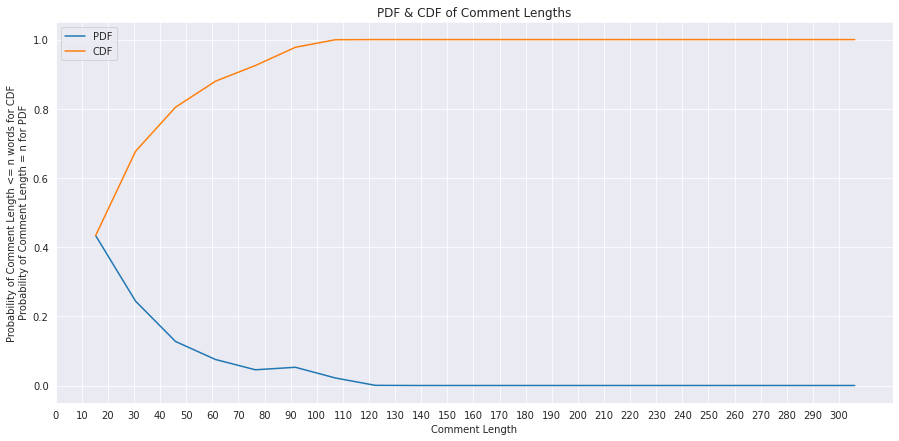

,percentile,length
0,99.0,96.0
1,99.1,96.0
2,99.2,97.0
3,99.3,97.0
4,99.4,98.0
5,99.5,99.0
6,99.6,100.0
7,99.7,101.0
8,99.8,102.0
9,99.9,105.0


In [ ]:
#Padding
comment_lengths = list(map(lambda x: len(x), X_train_seq))

counts, bin_edges = np.histogram(comment_lengths, bins=20, density=False) 
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)

#plot comment length distribution
sns.set_style('darkgrid')
plt.figure(figsize=(12,5))
plt.plot(bin_edges[1:], pdf)
plt.plot(bin_edges[1:], cdf)
plt.xlabel('Comment Length')
plt.ylabel('Probability of Comment Length <= n words for CDF\n Probability of Comment Length = n for PDF')
plt.title('PDF & CDF of Comment Lengths')
plt.xticks(np.arange(int(bin_edges[0]),int(bin_edges[-1]),10))
plt.legend(labels=['PDF','CDF'])
plt.show()

tmp = pd.DataFrame({'percentile':np.arange(99,100.1,0.1), 'length':np.percentile(comment_lengths, np.arange(99,100.1,0.1))})
tmp

In [ ]:
MAXLEN = 105
X_train_pad = pad_sequences(X_train_seq, maxlen = MAXLEN)
X_val_pad = pad_sequences(X_val_seq, maxlen = MAXLEN)
X_test_pad = pad_sequences(X_test_seq, maxlen = MAXLEN)

np.save('/content/gdrive/MyDrive/Jigsaw Files/Data Split/X_train_pad.npy', X_train_pad)
np.save('/content/gdrive/MyDrive/Jigsaw Files/Data Split/y_train.npy', y_train)

np.save('/content/gdrive/MyDrive/Jigsaw Files/Data Split/X_val_pad.npy', X_val_pad)
np.save('/content/gdrive/MyDrive/Jigsaw Files/Data Split/y_val.npy', y_val)

np.save('/content/gdrive/MyDrive/Jigsaw Files/Data Split/X_test_pad.npy', X_test_pad)

In [ ]:
#Tokenisation (No Data Splitting) 
X_train, y_train = train_pre['preprcsd'].values, train_pre['target'].values
X_test = test_pre['preprcsd'].values

tok = Tokenizer()
tok.fit_on_texts(X_train)
tok_path = '/content/gdrive/MyDrive/Jigsaw Files/No Split/tokenizer.pkl' #added later
pickle.dump(tok,  open(tok_path, 'wb'), protocol=pickle.HIGHEST_PROTOCOL) #added later
word_index = tok.word_index
pickle.dump(word_index, open('/content/gdrive/MyDrive/Jigsaw Files/No Split/word_index.pkl', 'wb'))

X_train_seq = tok.texts_to_sequences(X_train)
X_test_seq = tok.texts_to_sequences(X_test)

In [ ]:
comments_vocab = set(word_index.keys())
glove_vocab = set(glove.keys())
print('Unique Words in Comment Data:',len(comments_vocab))
print(f"Vocabulary Coverage: {round(len(comments_vocab.intersection(glove_vocab))/len(comments_vocab)*100, 2)}%")

Unique Words in Comment Data: 242594
Vocabulary Coverage: 53.44%


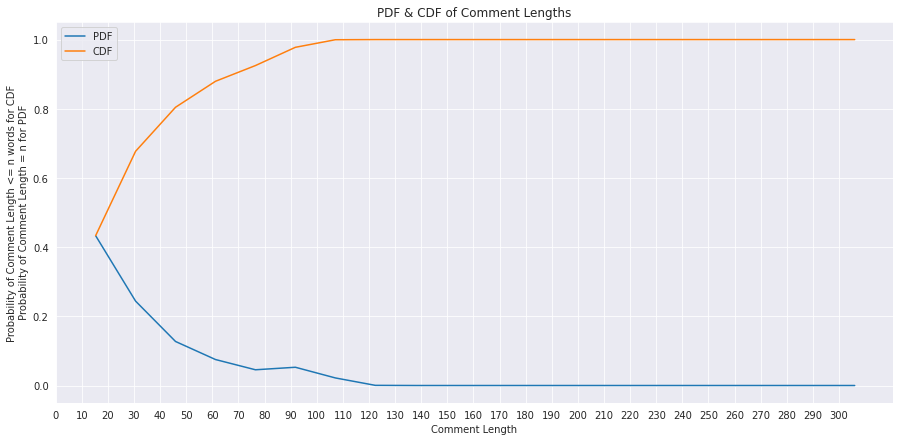

,percentile,length
0,99.0,96.0
1,99.1,96.0
2,99.2,97.0
3,99.3,98.0
4,99.4,98.0
5,99.5,99.0
6,99.6,100.0
7,99.7,101.0
8,99.8,103.0
9,99.9,105.0


In [ ]:
#Padding (No Data Splitting)
comment_lengths = list(map(lambda x: len(x), X_train_seq))

counts, bin_edges = np.histogram(comment_lengths, bins=20, density=False) 
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)

#plot comment length distribution
sns.set_style('darkgrid')
plt.figure(figsize=(12,5))
plt.plot(bin_edges[1:], pdf)
plt.plot(bin_edges[1:], cdf)
plt.xlabel('Comment Length')
plt.ylabel('Probability of Comment Length <= n words for CDF\n Probability of Comment Length = n for PDF')
plt.title('PDF & CDF of Comment Lengths')
plt.xticks(np.arange(int(bin_edges[0]),int(bin_edges[-1]),10))
plt.legend(labels=['PDF','CDF'])
plt.show()

tmp = pd.DataFrame({'percentile':np.arange(99,100.1,0.1), 'length':np.percentile(comment_lengths, np.arange(99,100.1,0.1))})
tmp

In [ ]:
MAXLEN = 105
X_train_pad = pad_sequences(X_train_seq, maxlen = MAXLEN)
X_test_pad = pad_sequences(X_test_seq, maxlen = MAXLEN)

np.save('/content/gdrive/MyDrive/Jigsaw Files/No Split/X_train_pad.npy', X_train_pad)
np.save('/content/gdrive/MyDrive/Jigsaw Files/No Split/y_train.npy', y_train)
np.save('/content/gdrive/MyDrive/Jigsaw Files/No Split/X_test_pad.npy', X_test_pad)

## **1.4 Build Embedding Matrix**

In [ ]:
def create_matrix(word_index, pre_trained):
    '''Returns a matrix where each index represents a word embedding.'''
    embed_mat = np.zeros(((len(word_index)+1),300))
    for word, index in word_index.items():
        if word in pre_trained:
            embed_mat[index] = pre_trained[word]
    return embed_mat

In [ ]:
#create embedding matrix for word_index obtained from 'data split' tokenised data
glove = pickle.load(open('/content/gdrive/MyDrive/Jigsaw Files/glove840B.pkl','rb'))
word_index = pickle.load(open('/content/gdrive/MyDrive/Jigsaw Files/Data Split/word_index.pkl', 'rb'))

embed_mat = create_matrix(word_index, glove)
np.save('/content/gdrive/MyDrive/Jigsaw Files/Data Split/embed_mat.npy', embed_mat)

In [ ]:
#create embedding matrix for word_index obtained from 'no split' tokenised data
glove = pickle.load(open('/content/gdrive/MyDrive/Jigsaw Files/glove840B.pkl','rb'))
word_index = pickle.load(open('/content/gdrive/MyDrive/Jigsaw Files/No Split/word_index.pkl', 'rb'))

embed_mat = create_matrix(word_index, glove)
np.save('/content/gdrive/MyDrive/Jigsaw Files/No Split/embed_mat.npy', embed_mat)

In [ ]:
del glove 
del word_index
del embed_mat
gc.collect()

271

## **1.5 Load Processed Data**

### **Padded sequence data (Data Split)**

In [3]:
X_train = np.load('/content/gdrive/MyDrive/Jigsaw Files/Data Split/X_train_pad.npy')
y_train = np.load('/content/gdrive/MyDrive/Jigsaw Files/Data Split/y_train.npy')

X_val = np.load('/content/gdrive/MyDrive/Jigsaw Files/Data Split/X_val_pad.npy')
y_val = np.load('/content/gdrive/MyDrive/Jigsaw Files/Data Split/y_val.npy')

X_test = np.load('/content/gdrive/MyDrive/Jigsaw Files/Data Split/X_test_pad.npy')

print('Shapes:',X_train.shape, X_val.shape, X_test.shape)

Shapes: (1443899, 105) (360975, 105) (97320, 105)


### **Embedding Matrix (Data Split)**

In [4]:
embed_mat = np.load('/content/gdrive/MyDrive/Jigsaw Files/Data Split/embed_mat.npy')
print('Shape:', embed_mat.shape)
embed_mat[:5]

Shape: (216851, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.04983   ,  0.02705   , -0.38787001, ..., -0.30357999,
         0.27074999,  0.18046001],
       [-0.049291  ,  0.20483001, -0.12808   , ..., -0.28529   ,
         0.33702999,  0.12335   ],
       [-0.14121   ,  0.034641  , -0.44299999, ..., -0.29866001,
         0.013515  ,  0.025409  ],
       [-0.26879001,  0.17483   , -0.35633001, ..., -0.17138   ,
         0.26846001,  0.19866   ]])

### **Toxicity and Identity data**

In [5]:
toxicity_feat = ['target_cont','severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
identity_main = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',  'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [6]:
toxicity_data = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/toxicity_data.csv')
print("Shape:",toxicity_data.shape)
toxicity_data.head()

Shape: (1804874, 7)


,target_cont,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
4,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0


In [7]:
identity_data = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/identity_data.csv')
for col in identity_data.columns:
    identity_data[col].fillna(0, inplace=True)
    if col=='target_cont':
        identity_data['target'] = identity_data[col].apply(lambda x: 1 if x>=0.5 else 0).astype(int)
    else:
        identity_data[col] = identity_data[col].apply(lambda x: 1 if x>=0.5 else 0).astype(int)
print("Shape:",identity_data.shape)
identity_data.head()

Shape: (1804874, 11)


,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target_cont,target
0,0,0,0,0,0,0,0,0,0,0.000000,0
1,0,0,0,0,0,0,0,0,0,0.000000,0
2,0,0,0,0,0,0,0,0,0,0.000000,0
3,0,0,0,0,0,0,0,0,0,0.000000,0
4,0,0,0,0,0,0,0,0,0,0.893617,1


In [8]:
#split toxicity and identity data with seed which is used to split the comments data
toxic_train , toxic_val, id_train, id_val = train_test_split(toxicity_data, identity_data, test_size=0.2, stratify= identity_data['target'], random_state=42)

# **2. Define Functions to compute Custom Metric : Generalized AUC**
(metric overview - https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation)

In [9]:
#code snippet - https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive
TARGET_COLUMN = 'target'

def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]==1]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name]) 

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[(df[subgroup]==1) & (df[label]==0)]
    non_subgroup_positive_examples = df[(df[subgroup]==0) & (df[label]==1)]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[(df[subgroup]==1) & (df[label]==1)]
    non_subgroup_negative_examples = df[(df[subgroup]==0) & (df[label]==0)]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, model, label_col, include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]==1])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)
    
def calculate_overall_auc(df, model_name):
    '''Calculates the AUC for all data.'''
    true_labels = df[TARGET_COLUMN]
    predicted_labels = df[model_name]
    return roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25, Wa = 0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score) # code logic : 3/4*(a+b+c/3) == 1/4(a+b+c)

# **3. Model Experimentation**

**Things to try:**
- **Different Model Architectures**
- **Using Sample Weighted Loss where in Sample Weights are computed in reference to Evaluation Metric (i.e. Generalized AUC)** : AUC or Generalized AUC in this case are metrics that cannot directly be used as loss to optimize the model because they aren't differentiable, they can only be used for hyperparameter tuning. We use the Binary Cross Entropy loss as usual to optimize the model not the regular one but a weighted one where we provide appropriate weights (based on the evaluation metric) to each sample in the training set.
-  **Introducing auxiliary targets to improve the model performance** : The real valued toxicity features are used as auxiliary targets. Here we apply usual Binary Cross Entropy loss although the features are real valued. Its noted that BCE loss between 2 real values in the range 0 to 1 increases if the difference is more and decreases if the difference is less so it works in the same way as it does b/w 1 binary and 1 real value and our aim is to use the auxiliary targets so that the model optimizes itself better. 
- **Weighted Average of Predictions** : We obtain test predictions after each epoch simulataneaously changing the learning rate then average over all the predictions.

## **3.1 Class Weights & Callbacks**

In [10]:
def get_class_weights(y):
    class_weight_arr = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(zip(np.unique(y), class_weight_arr))
    return class_weight_dict

cw = get_class_weights(y_train)
print('Class Weights:', cw)

Class Weights: {0: 0.5434598835318631, 1: 6.2524314306252}


In [11]:
#callbacks
earlystop_cb = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                                                   patience=3, verbose=1, mode='min', restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', patience = 2, factor = 0.5, mode='min', min_delta = 0.0001, min_lr=1e-7)
callbacks = [earlystop_cb, reduce_lr_cb]

## **3.2 Define Helper Functions : Save and Load, Probability Threshold, ROC-AUC, Confusion Matrix**

In [12]:
'''Helper Functions - to save and load models'''

def save_model(model,path):
    config = tf.keras.layers.serialize(model)
    pickle.dump(config, open(path+'.pkl','wb'))
    model.save_weights(path+'_weights.h5')
    return 

def load_model(path, contain_custom_obj=False):
    config = pickle.load(open(path+'.pkl','rb'))
    if contain_custom_obj:
        custom_objects = {"AttentionWithContext": AttentionWithContext}
        with tf.keras.utils.custom_object_scope(custom_objects):
            model = tf.keras.Model.from_config(config['config'])
    else: 
        model = tf.keras.Model().from_config(config['config'])
    model.load_weights(path+'_weights.h5')
    return model

In [13]:
'''Helper Functions - to find and predict with best threshold'''

#Best threshold is the one where TPR is high and FPR is low
#so we need to maximize TPR and minimize FPR or in other words maximize (1-FPR), therefore we use TPR*(1-FPR) as a metric to find the best threshold
def find_best_threshold(threshold, fpr, tpr):
    #np.argmax returns the index of the highest valued element in the list 
    thresh = threshold[np.argmax(tpr*(1-fpr))] 
    print("The maximum value of TPR*(1-FPR)", max(tpr*(1-fpr)), "for threshold", np.round(thresh,3))
    return thresh

#below function uses the best threshold value as a condition to obtain predicted target classes (i.e. y_pred) from model predicted probabilities
#obtaining y_pred is essential for our next step which is evaluating the model performance
def predict_with_best_t(y_prob, thresh):
    y_pred = np.array([0 if x<thresh else 1 for x in y_prob])
    return y_pred

In [ ]:
'''Helper Function - to plot roc curve and confusion matrix for Set-1 Models'''

def plot_roc_confusion(model_name, only):
    auc_train = roc_auc_score(y_train, id_train[model_name].values)
    auc_val = roc_auc_score(y_val, id_val[model_name].values)

    train_fpr, train_tpr, train_thresh = roc_curve(y_train, id_train[model_name])
    val_fpr, val_tpr, val_thresh = roc_curve(y_val, id_val[model_name])

    print(f'Overall AUC (Train): {auc_train}')
    print(f'Overall AUC (Validation): {auc_val}')

    best_thresh = find_best_threshold(train_thresh, train_fpr, train_tpr)

    y_train_hat = predict_with_best_t(id_train[model_name].values, best_thresh)
    y_val_hat = predict_with_best_t(id_val[model_name].values, best_thresh)

    confusion_train = confusion_matrix(y_train, y_train_hat)
    confusion_val = confusion_matrix(y_val, y_val_hat)

    fig, ax = plt.subplots(nrows=1,ncols=3, figsize = (30,6))

    ax[0].plot(train_fpr, train_tpr, label='Train AUC = '+str(auc(train_fpr, train_tpr)))
    ax[0].plot(val_fpr, val_tpr, label='Val AUC = '+str(auc(val_fpr, val_tpr)))
    ax[0].set(xlabel = "False Positive Rate (FPR)", ylabel ="True Positive Rate (TPR)", title = "ROC Curve")
    ax[0].legend()
    ax[0].grid()

    cm_train_df = pd.DataFrame(confusion_train,
                    index = [0, 1], 
                    columns = [0, 1])
    sns.heatmap(cm_train_df, annot=True, fmt='g', ax=ax[1])
    ax[1].set(title = 'Confusion Matrix of Train', ylabel='Actual Values', xlabel='Predicted Values')

    cm_val_df = pd.DataFrame(confusion_val,
            index = [0, 1], 
            columns = [0, 1])
    sns.heatmap(cm_val_df, annot=True, fmt='g', ax=ax[2])
    ax[2].set(title = 'Confusion Matrix of Validation', ylabel='Actual Values', xlabel='Predicted Values')
    return plt.show()

In [40]:
'''Helper Function - to plot roc curve and confusion matrix for Model-4'''

def plot_roc_confusion_(model_name):
    auc_train = roc_auc_score(y_train[:,0], identity_data[model_name].values)
    
    train_fpr, train_tpr, train_thresh = roc_curve(y_train[:,0], identity_data[model_name])
    print(f'Overall AUC (Train): {auc_train}')

    best_thresh = find_best_threshold(train_thresh, train_fpr, train_tpr)

    y_train_hat = predict_with_best_t(identity_data[model_name].values, best_thresh)

    confusion_train = confusion_matrix(y_train[:,0], y_train_hat)

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize = (18,6))

    ax[0].plot(train_fpr, train_tpr, label='Train AUC = '+str(auc(train_fpr, train_tpr)))
    ax[0].set(xlabel = "False Positive Rate (FPR)", ylabel ="True Positive Rate (TPR)", title = "ROC Curve")
    ax[0].legend()
    ax[0].grid()

    cm_train_df = pd.DataFrame(confusion_train,
                    index = [0, 1], 
                    columns = [0, 1])
    sns.heatmap(cm_train_df, annot=True, fmt='g', ax=ax[1])
    ax[1].set(title = 'Confusion Matrix of Train', ylabel='Actual Values', xlabel='Predicted Values')
    return plt.show()

## **3.3 Build and Train Models (Set-1)**

## **Model - 1**
Features:
- BiLSTM(128) and a BiGRU(128) layer 
- No Attention Mechanism implemented
- GlobalAveragePooling1D, GlobalMaxPool1D layers included
- BCE Loss with Class Weighting

In [14]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#config
SEED = 420
INPUT_LEN = 105 
DROPOUT_RATIO = 0.25
LSTM_UNITS = 128
GRU_UNITS = 128
ATT_UNITS = 128
DENSE_UNITS = 512

In [ ]:
#architecture
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.backend.clear_session()

sequences = Input(shape=(INPUT_LEN,))
x = Embedding(input_dim=embed_mat.shape[0], output_dim=embed_mat.shape[1], input_length = INPUT_LEN, weights=[embed_mat], trainable=False)(sequences) 
x = SpatialDropout1D(DROPOUT_RATIO)(x)
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, return_state=False))(x)  
x = Bidirectional(GRU(GRU_UNITS, return_sequences=True, return_state=False))(x)

p1 = GlobalMaxPool1D()(x)
p2 = GlobalAveragePooling1D()(x)

x = Concatenate()([p1,p2])
x = Add()([x, Dense(DENSE_UNITS, activation='relu')(x)])
x = Add()([x, Dense(DENSE_UNITS, activation='relu')(x)])
preds = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs=sequences, outputs=preds)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 105, 300)     65055300    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 105, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 105, 256)     439296      ['spatial_dropout1d[0][0]']  

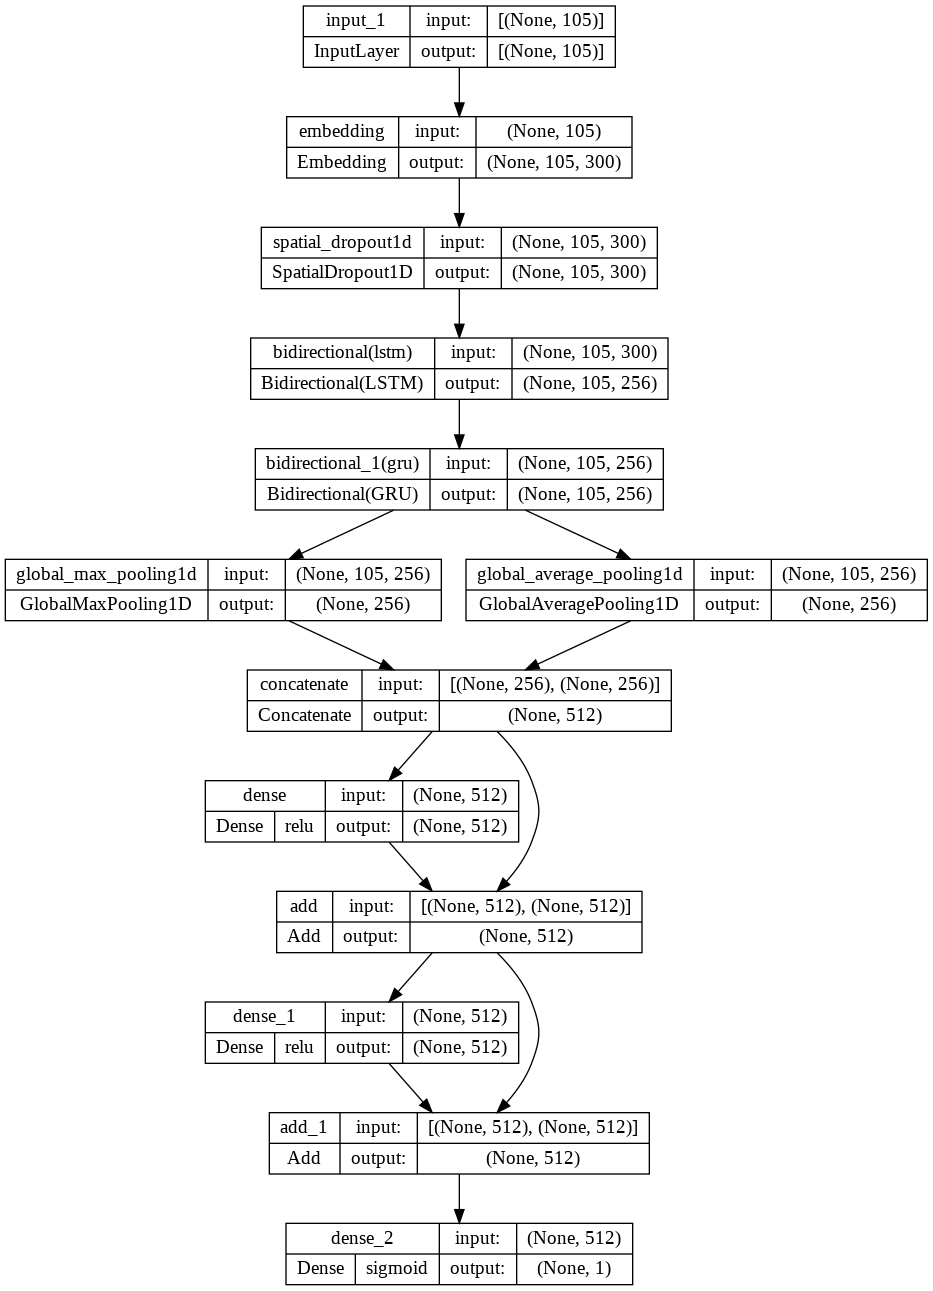

In [ ]:
tf.keras.utils.plot_model(model_1, to_file='/content/gdrive/MyDrive/Jigsaw Files/Model Graphs/model_1.png', show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
model_1.compile(loss='binary_crossentropy', optimizer='adam')
history_1 = model_1.fit(x = X_train, y = y_train, validation_data= (X_val, y_val), batch_size = 2048, class_weight = cw, 
                        callbacks=callbacks, epochs = 10, verbose = 1) 

Epoch 1/10
706/706 [==============================] - 334s 458ms/step - loss: 0.3186 - val_loss: 0.3080 - lr: 0.0010
Epoch 2/10
706/706 [==============================] - 324s 459ms/step - loss: 0.2751 - val_loss: 0.2920 - lr: 0.0010
Epoch 3/10
706/706 [==============================] - 323s 458ms/step - loss: 0.2615 - val_loss: 0.2745 - lr: 0.0010
Epoch 4/10
706/706 [==============================] - 323s 458ms/step - loss: 0.2525 - val_loss: 0.2258 - lr: 0.0010
Epoch 5/10
706/706 [==============================] - 323s 458ms/step - loss: 0.2444 - val_loss: 0.3193 - lr: 0.0010
Epoch 6/10
706/706 [==============================] - 323s 458ms/step - loss: 0.2375 - val_loss: 0.3329 - lr: 0.0010
Epoch 7/10
706/706 [==============================] - 324s 458ms/step - loss: 0.2224 - val_loss: 0.2895 - lr: 5.0000e-04
Epoch 7: early stopping


In [17]:
filepath = '/content/gdrive/MyDrive/Jigsaw Files/Models & Weights/model_1'

# save_model(model_1, filepath)
model_1 = load_model(filepath)

In [18]:
#check train GAUC
y_train_pred = model_1.predict(X_train, batch_size=2048, verbose=1)
id_train['Model_1'] = y_train_pred

bias_metrics_train = compute_bias_metrics_for_model(id_train, identity_main, 'Model_1', 'target')
custom_train = get_final_metric(bias_metrics_train, calculate_overall_auc(id_train, 'Model_1'))
print('Generalized AUC (Train):', custom_train)

706/706 [==============================] - 93s 129ms/step
Generalized AUC (Train): 0.9304207436984797


In [19]:
bias_metrics_train

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,8834,0.846289,0.864968,0.964570
6,black,11822,0.853615,0.865506,0.966012
7,white,20064,0.858486,0.878540,0.963811
5,muslim,16797,0.869208,0.893264,0.961087
4,jewish,6139,0.893555,0.937127,0.945577
8,psychiatric_or_mental_illness,3971,0.921529,0.908850,0.971909
0,male,35572,0.927411,0.937219,0.962560
1,female,42634,0.929268,0.944382,0.958937
3,christian,32260,0.939053,0.963932,0.945806


In [20]:
#check validation GAUC
y_val_pred = model_1.predict(X_val, batch_size=2048, verbose=1)
id_val['Model_1'] = y_val_pred

bias_metrics_val = compute_bias_metrics_for_model(id_val, identity_main, 'Model_1', 'target')
custom_val = get_final_metric(bias_metrics_val, calculate_overall_auc(id_val, 'Model_1'))
print('Generalized AUC (Validation):', custom_val)

177/177 [==============================] - 23s 131ms/step
Generalized AUC (Validation): 0.9189672203872907


In [21]:
bias_metrics_val  

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,2163,0.825136,0.846114,0.959127
6,black,3079,0.836991,0.842565,0.962960
7,white,5018,0.847991,0.861059,0.960284
5,muslim,4209,0.857943,0.871287,0.958545
4,jewish,1512,0.875120,0.920088,0.938992
0,male,8912,0.915431,0.923729,0.956040
8,psychiatric_or_mental_illness,918,0.917117,0.892606,0.970260
3,christian,8163,0.917198,0.954432,0.929073
1,female,10795,0.918220,0.932529,0.952155


Overall AUC (Train): 0.9663211742730954
Overall AUC (Validation): 0.9587479492444273
The maximum value of TPR*(1-FPR) 0.8183511862254977 for threshold 0.446


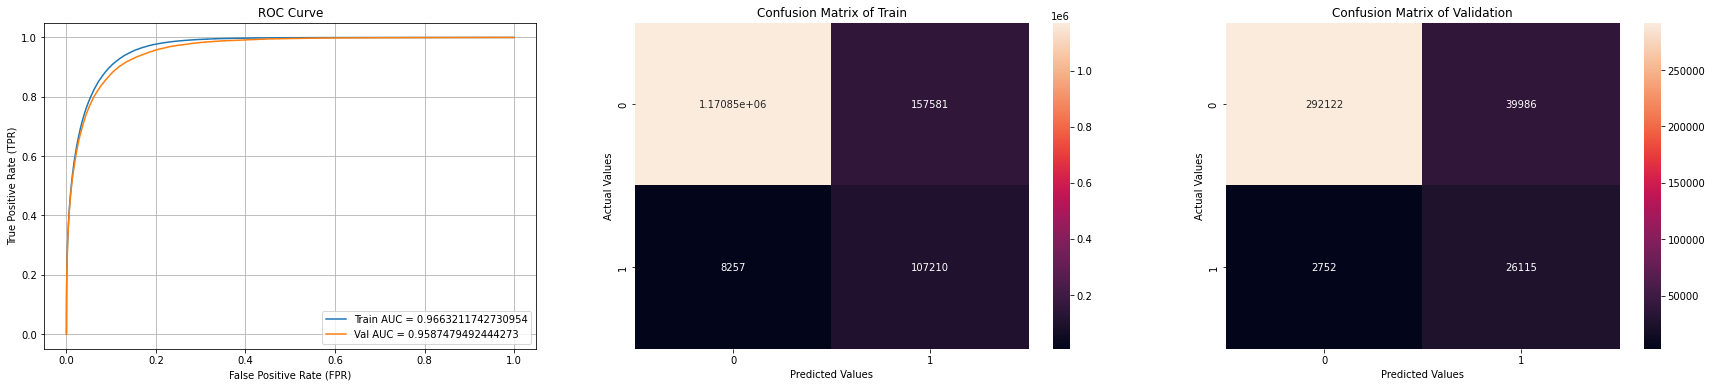

In [25]:
MODEL_NAME = 'Model_1'
plot_roc_confusion(MODEL_NAME)

In [ ]:
#submit and check test GAUC
y_test_pred = model_1.predict(X_test, batch_size=2048, verbose=1)

submission = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/test.csv')
submission = submission.iloc[:,0:1]
submission['prediction'] = y_test_pred
submission.head()

48/48 [==============================] - 7s 139ms/step


,id,prediction
0,7097320,0.004652
1,7097321,0.047119
2,7097322,0.329986
3,7097323,0.000641
4,7097324,0.001580


In [ ]:
submission.to_csv('jigsaw_submit_1.csv', index=False)

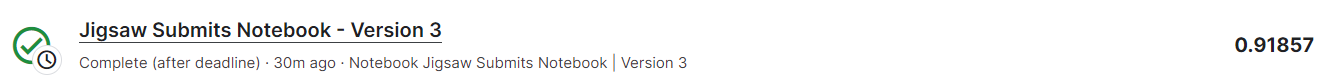

## **Model - 2**
Features:
- Single BiLSTM(128) layer 
- Attention(128), GlobalMaxPool1D layers included
- BCE Loss with Class Weighting

### **Custom Attention Layer**

In [26]:
#code reference - https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/ 
class AttentionWithContext(Layer):
    """
    Basically, hidden state of each timestep is passed through a hidden dense layer of n units, with a softmax layer on top which returns the attention weights for each timestep.
    The context vector is then calculated as the attention weighted sum of timestep hidden states.
    Input shape
        3D tensor with shape: (samples, steps, features).
    Output shape
        2D tensor with shape: (samples, features).
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, units=None,return_weights=False,**kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_weights = return_weights
        self.units = units
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        
        if self.units!=None:
            num_units = self.units
        else:
            num_units = input_shape[-1]
            
        self.W = self.add_weight(name = 'att_W',
                             shape =  (input_shape[-1], num_units),
                             initializer=self.init,
                             regularizer=self.W_regularizer,
                             constraint=self.W_constraint,
                             trainable=True)
        if self.bias:
            self.b = self.add_weight(name = 'att_b',
                                 shape = (num_units,),
                                 initializer='zero',
                                 regularizer=self.b_regularizer,
                                 constraint=self.b_constraint,
                                 trainable=True)
        self.u = self.add_weight(name = 'att_u',
                                 shape = (num_units,1),
                                 initializer=self.init,
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint,
                                 trainable=True)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.matmul(x, self.W) #x(256,).W(256,128) -> uit(128,)

        if self.bias:
            uit += self.b #uit(128,)+b(128,) -> uit(128,)

        uit = tf.keras.activations.tanh(uit) #uit(128,)
        ait = tf.matmul(uit, self.u) #uit(128,).u(128,) -> ait(1,)

        a = tf.keras.activations.exponential(ait) #a(105,1) for all timesteps

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= tf.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) 

        weighted_input = x * a #x(105,256)*a(105,1)
        weighted_sum = K.sum(weighted_input,axis=1) #weighted_sum(256,) : context vector
        if self.return_weights:
            return [weighted_sum, a]
        return weighted_sum

    def compute_output_shape(self, input_shape):
        if self.units!=None:
            return input_shape[0], self.units
        return input_shape[0], input_shape[-1]
    
    def get_config(self):
        config = super(AttentionWithContext, self).get_config().copy()
        config.update({
            'W_regularizer': self.W_regularizer,
            'u_regularizer': self.u_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'u_constraint': self.u_constraint,
            'b_constraint': self.b_constraint,
            'bias' : self.bias,
            'units': self.units,
            'return_weights' : self.return_weights
        })
        return config

In [ ]:
#config
SEED = 420
INPUT_LEN = 105 
SP_DROPOUT_RATIO = 0.2
DROPOUT_RATIO = 0.4
LSTM_UNITS = 128
ATT_UNITS = 128
DENSE_UNITS = 512

In [ ]:
#architecture
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.backend.clear_session()

sequences = Input(shape = (INPUT_LEN,))
x = Embedding(input_dim=embed_mat.shape[0], output_dim=embed_mat.shape[1], input_length = INPUT_LEN, weights=[embed_mat], trainable=False)(sequences)
x = SpatialDropout1D(SP_DROPOUT_RATIO)(x)

x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)

a = AttentionWithContext(units=ATT_UNITS)(x)
p = GlobalMaxPool1D()(x) 

x = Concatenate()([a,p])
x = Dense(DENSE_UNITS, activation = "relu")(x)
x = Dropout(DROPOUT_RATIO)(x)
preds = Dense(1, activation = "sigmoid")(x)

model_2 = Model(inputs = sequences, outputs = preds)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 105, 300)     65055300    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 105, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 105, 256)     439296      ['spatial_dropout1d[0][0]']  

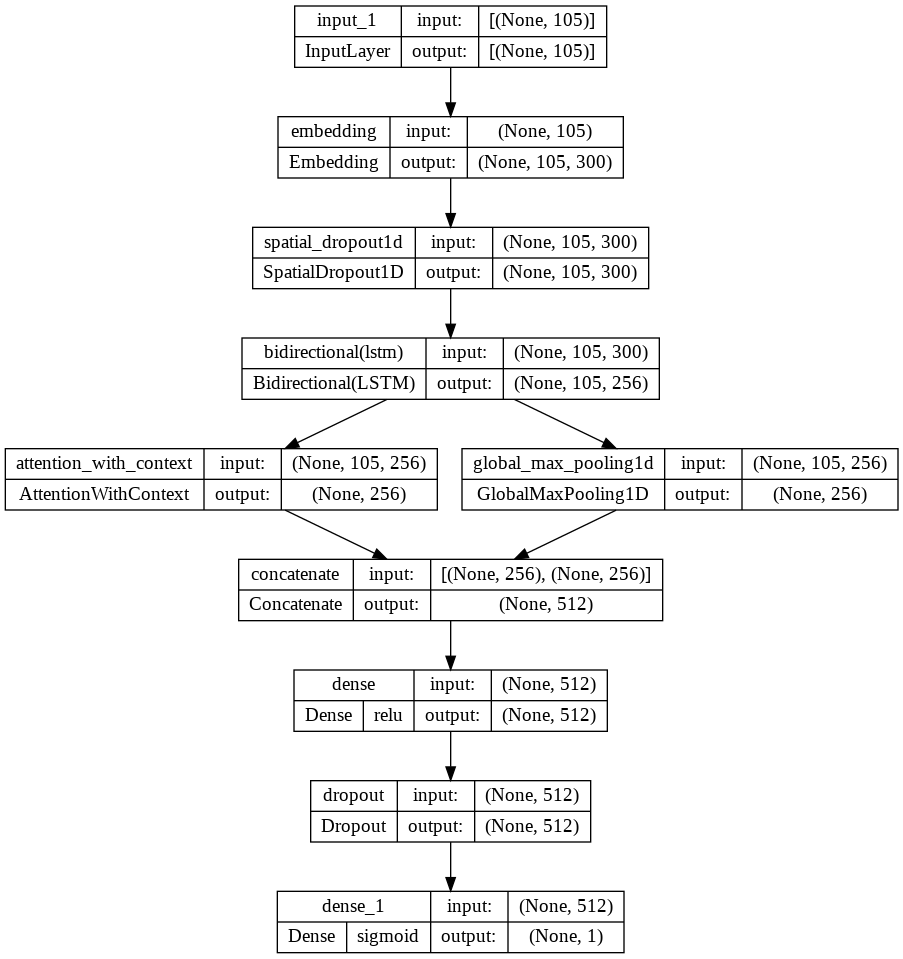

In [ ]:
tf.keras.utils.plot_model(model_2, to_file='/content/gdrive/MyDrive/Jigsaw Files/Model Graphs/model_2.png', show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
model_2.compile(loss='binary_crossentropy', optimizer='adam')
history_2 = model_2.fit(x = X_train, y = y_train, validation_data= (X_val, y_val), batch_size = 2048, class_weight = cw, 
                        callbacks = callbacks, epochs = 10, verbose = 1)

Epoch 1/10
706/706 [==============================] - 216s 301ms/step - loss: 0.3187 - val_loss: 0.2940 - lr: 0.0010
Epoch 2/10
706/706 [==============================] - 210s 298ms/step - loss: 0.2766 - val_loss: 0.2751 - lr: 0.0010
Epoch 3/10
706/706 [==============================] - 210s 297ms/step - loss: 0.2637 - val_loss: 0.2635 - lr: 0.0010
Epoch 4/10
706/706 [==============================] - 210s 298ms/step - loss: 0.2556 - val_loss: 0.2293 - lr: 0.0010
Epoch 5/10
706/706 [==============================] - 210s 297ms/step - loss: 0.2477 - val_loss: 0.3512 - lr: 0.0010
Epoch 6/10
706/706 [==============================] - 210s 297ms/step - loss: 0.2422 - val_loss: 0.3266 - lr: 0.0010
Epoch 7/10
706/706 [==============================] - 210s 297ms/step - loss: 0.2277 - val_loss: 0.2755 - lr: 5.0000e-04
Epoch 7: early stopping


In [27]:
filepath = '/content/gdrive/MyDrive/Jigsaw Files/Models & Weights/model_2'

# save_model(model_2, filepath)
model_2 = load_model(filepath, contain_custom_obj=True)

In [28]:
#check train GAUC
y_train_pred = model_2.predict(X_train, batch_size=2048, verbose=1)
id_train['Model_2'] = y_train_pred

bias_metrics_train = compute_bias_metrics_for_model(id_train, identity_main, 'Model_2', 'target')
custom_train = get_final_metric(bias_metrics_train, calculate_overall_auc(id_train, 'Model_2'))
print('Generalized AUC (Train):', custom_train)

706/706 [==============================] - 58s 81ms/step
Generalized AUC (Train): 0.928750011640381


In [29]:
bias_metrics_train

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
6,black,11822,0.848637,0.852106,0.967801
2,homosexual_gay_or_lesbian,8834,0.848906,0.860988,0.965173
7,white,20064,0.856657,0.874397,0.963908
5,muslim,16797,0.869400,0.884082,0.963575
4,jewish,6139,0.895637,0.925707,0.952798
8,psychiatric_or_mental_illness,3971,0.919079,0.907212,0.971040
0,male,35572,0.926010,0.933328,0.963030
1,female,42634,0.927263,0.940230,0.959588
3,christian,32260,0.938284,0.960637,0.947575


In [30]:
#check validation GAUC
y_val_pred = model_2.predict(X_val, batch_size=2048, verbose=1)
id_val['Model_2'] = y_val_pred

bias_metrics_val = compute_bias_metrics_for_model(id_val, identity_main, 'Model_2', 'target')
custom_val = get_final_metric(bias_metrics_val, calculate_overall_auc(id_val, 'Model_2'))
print('Generalized AUC (Validation):', custom_val)

177/177 [==============================] - 15s 82ms/step
Generalized AUC (Validation): 0.9170004849461841


In [31]:
bias_metrics_val

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,2163,0.822652,0.839493,0.959808
6,black,3079,0.831415,0.828968,0.964764
7,white,5018,0.843464,0.857496,0.959769
5,muslim,4209,0.856915,0.862219,0.960931
4,jewish,1512,0.874459,0.908145,0.945749
0,male,8912,0.913776,0.920251,0.956740
8,psychiatric_or_mental_illness,918,0.915997,0.893152,0.968892
3,christian,8163,0.916949,0.950497,0.932392
1,female,10795,0.917648,0.928738,0.953671


Overall AUC (Train): 0.9653605113581238
Overall AUC (Validation): 0.9580739527014833
The maximum value of TPR*(1-FPR) 0.8153977063346688 for threshold 0.447


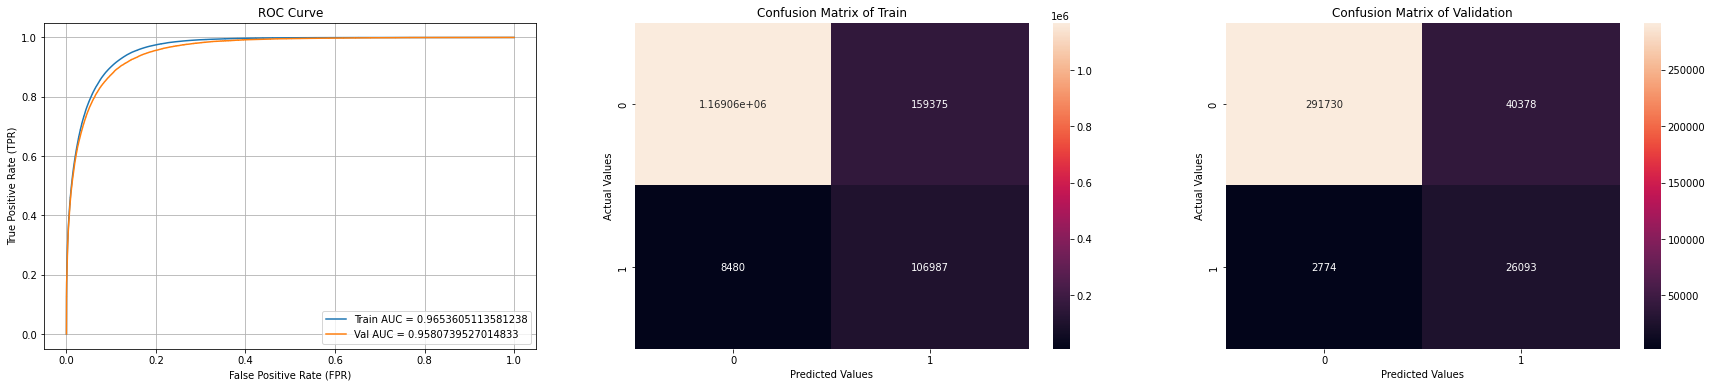

In [32]:
MODEL_NAME = 'Model_2'
plot_roc_confusion(MODEL_NAME)

In [ ]:
#submit and check test GAUC
y_test_pred = model_2.predict(X_test, batch_size=2048, verbose=1)

submission = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/test.csv')
submission = submission.iloc[:,0:1]
submission['prediction'] = y_test_pred
submission.head()

48/48 [==============================] - 4s 88ms/step


,id,prediction
0,7097320,0.004746
1,7097321,0.075389
2,7097322,0.281497
3,7097323,0.001572
4,7097324,0.002543


In [ ]:
submission.to_csv('jigsaw_submit_2.csv', index=False)

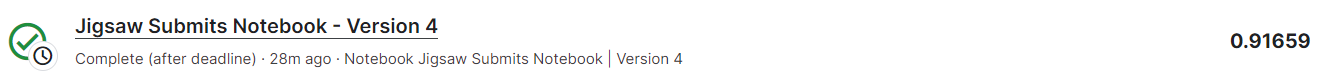

## **Model - 3**
Features:
- 2 BiLSTM(128) layers 
- Attention(128), GlobalAveragePooling1D, GlobalMaxPool1D layers included
- BCE Loss with Class Weighting

In [ ]:
#config
SEED = 420
INPUT_LEN = 105 
SP_DROPOUT_RATIO = 0.2
DROPOUT_RATIO = 0.4
LSTM_UNITS = 128
ATT_UNITS = 128
DENSE_UNITS = 768

In [ ]:
#architecture
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.backend.clear_session()

sequences = Input(shape = (INPUT_LEN,))
x = Embedding(input_dim=embed_mat.shape[0], output_dim=embed_mat.shape[1], input_length = INPUT_LEN, weights=[embed_mat], trainable=False)(sequences)
x = SpatialDropout1D(SP_DROPOUT_RATIO)(x)

x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)

a = AttentionWithContext(units=ATT_UNITS)(x)
p1 = GlobalAveragePooling1D()(x)
p2 = GlobalMaxPool1D()(x) 

x = Concatenate()([a,p1,p2])
x = Add()([x, Dense(DENSE_UNITS, activation='relu')(x)])
x = Add()([x, Dense(DENSE_UNITS, activation='relu')(x)])
x = Dropout(DROPOUT_RATIO)(x)
preds = Dense(1, activation = "sigmoid")(x)

model_3 = Model(inputs=sequences, outputs=preds)
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 105, 300)     65055300    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 105, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 105, 256)     439296      ['spatial_dropout1d[0][0]']  

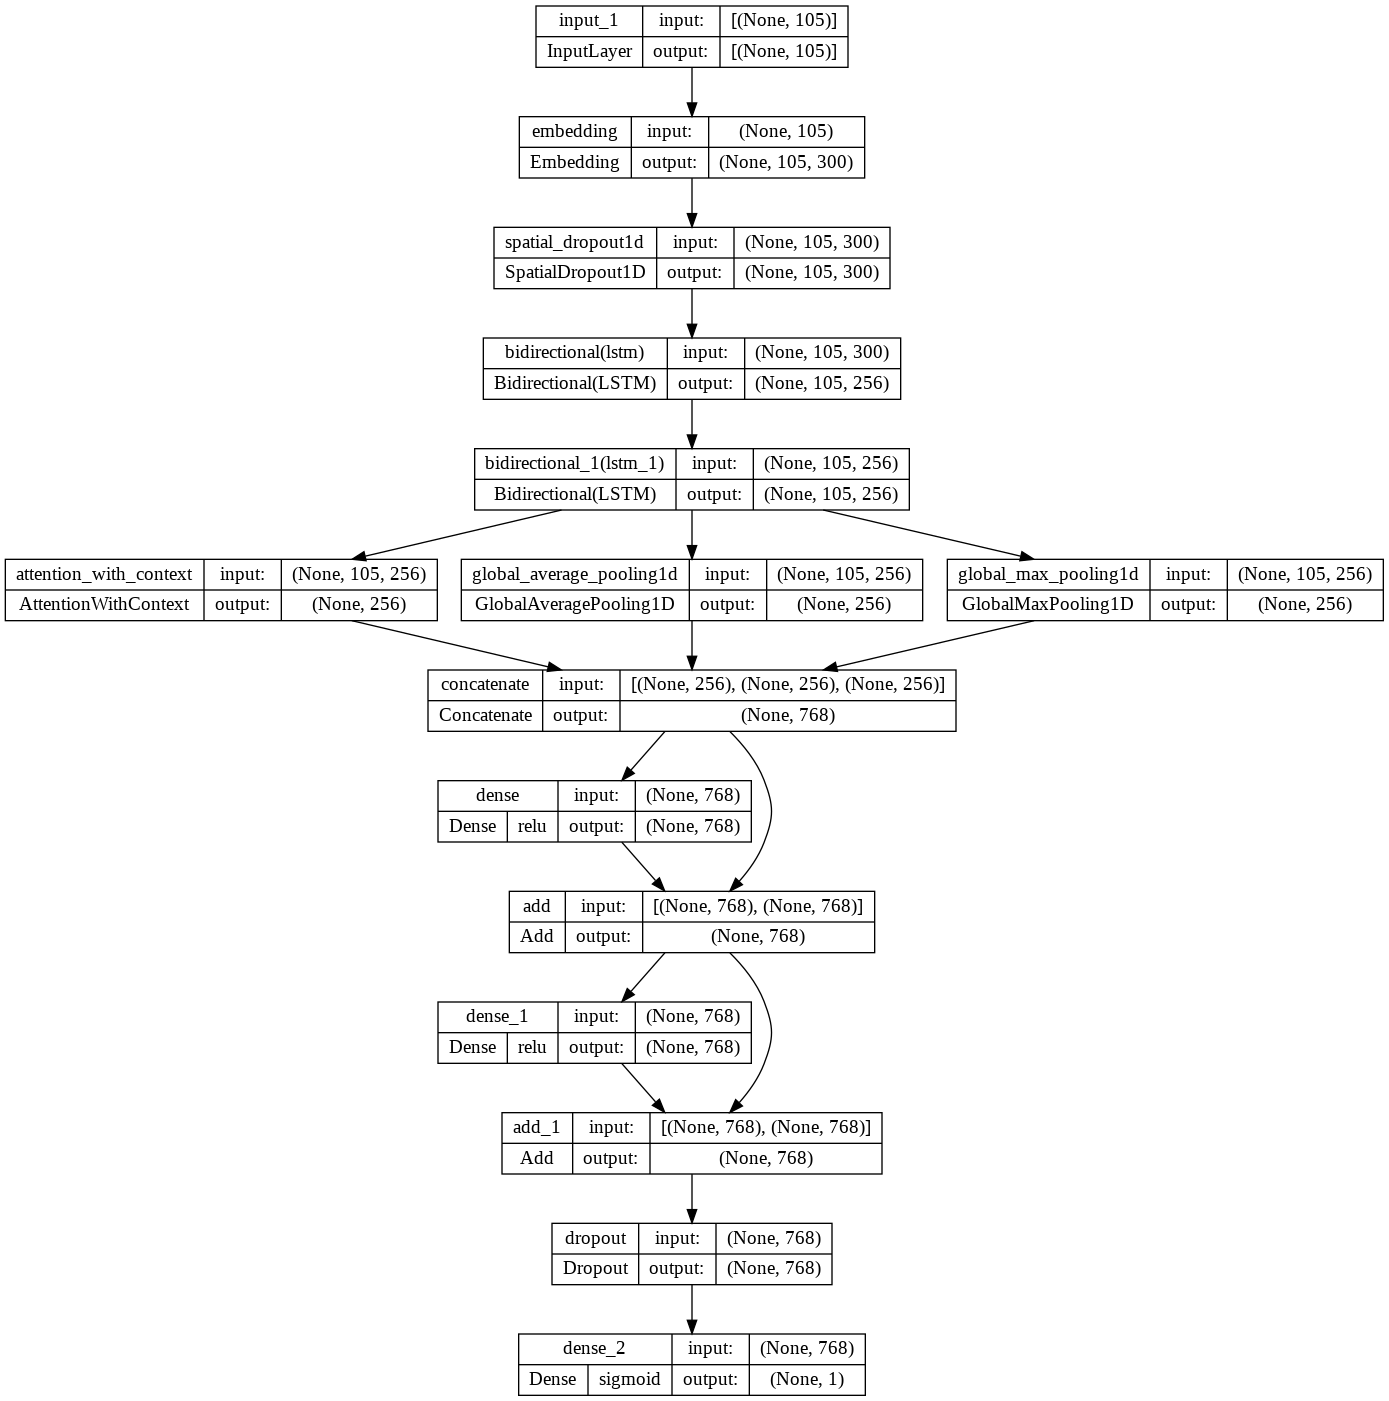

In [ ]:
tf.keras.utils.plot_model(model_3, to_file='/content/gdrive/MyDrive/Jigsaw Files/Model Graphs/model_3.png', show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
model_3.compile(loss='binary_crossentropy', optimizer='adam')
history_3 = model_3.fit(x = X_train, y = y_train, validation_data= (X_val, y_val), batch_size = 2048, class_weight = cw, 
                        callbacks = callbacks, epochs = 10, verbose = 1) 

Epoch 1/10
706/706 [==============================] - 388s 540ms/step - loss: 0.3200 - val_loss: 0.3107 - lr: 0.0010
Epoch 2/10
706/706 [==============================] - 378s 535ms/step - loss: 0.2746 - val_loss: 0.2710 - lr: 0.0010
Epoch 3/10
706/706 [==============================] - 377s 535ms/step - loss: 0.2607 - val_loss: 0.2721 - lr: 0.0010
Epoch 4/10
706/706 [==============================] - 378s 535ms/step - loss: 0.2517 - val_loss: 0.2241 - lr: 0.0010
Epoch 5/10
706/706 [==============================] - 377s 534ms/step - loss: 0.2427 - val_loss: 0.3005 - lr: 0.0010
Epoch 6/10
706/706 [==============================] - 377s 534ms/step - loss: 0.2350 - val_loss: 0.3367 - lr: 0.0010
Epoch 7/10
706/706 [==============================] - 377s 535ms/step - loss: 0.2172 - val_loss: 0.2860 - lr: 5.0000e-04
Epoch 7: early stopping


In [33]:
filepath = '/content/gdrive/MyDrive/Jigsaw Files/Models & Weights/model_3'

# save_model(model_3, filepath)
model_3 = load_model(filepath, contain_custom_obj=True)

In [34]:
#check train GAUC
y_train_pred = model_3.predict(X_train, batch_size=2048, verbose=1)
id_train['Model_3'] = y_train_pred

bias_metrics_train = compute_bias_metrics_for_model(id_train, identity_main, 'Model_3', 'target')
custom_train = get_final_metric(bias_metrics_train, calculate_overall_auc(id_train, 'Model_3'))
print('Generalized AUC (Train):', custom_train)

706/706 [==============================] - 112s 156ms/step
Generalized AUC (Train): 0.9303270068017923


In [35]:
bias_metrics_train

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,8834,0.849288,0.866383,0.964888
6,black,11822,0.852783,0.856394,0.968492
7,white,20064,0.858013,0.880410,0.963325
5,muslim,16797,0.868106,0.892581,0.961306
4,jewish,6139,0.893133,0.934585,0.947617
8,psychiatric_or_mental_illness,3971,0.920521,0.913146,0.969989
0,male,35572,0.927497,0.936350,0.963280
1,female,42634,0.928809,0.942913,0.959892
3,christian,32260,0.938865,0.963144,0.946678


In [36]:
#check validation GAUC
y_val_pred = model_3.predict(X_val, batch_size=2048)
id_val['Model_3'] = y_val_pred

bias_metrics_val = compute_bias_metrics_for_model(id_val, identity_main, 'Model_3', 'target')
custom_val = get_final_metric(bias_metrics_val, calculate_overall_auc(id_val, 'Model_3'))
print('Generalized AUC (Validation):', custom_val)

177/177 [==============================] - 29s 162ms/step
Generalized AUC (Validation): 0.9180496504247576


In [37]:
bias_metrics_val

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,2163,0.821735,0.845062,0.958625
6,black,3079,0.831461,0.833092,0.964272
7,white,5018,0.844559,0.862287,0.959239
5,muslim,4209,0.856020,0.871259,0.958314
4,jewish,1512,0.870828,0.917008,0.939782
0,male,8912,0.916004,0.923297,0.956663
3,christian,8163,0.917535,0.953741,0.929945
8,psychiatric_or_mental_illness,918,0.917962,0.895164,0.969334
1,female,10795,0.919156,0.931419,0.953478


Overall AUC (Train): 0.9664433793741019
Overall AUC (Validation): 0.9587785247292504
The maximum value of TPR*(1-FPR) 0.8187278905820242 for threshold 0.457


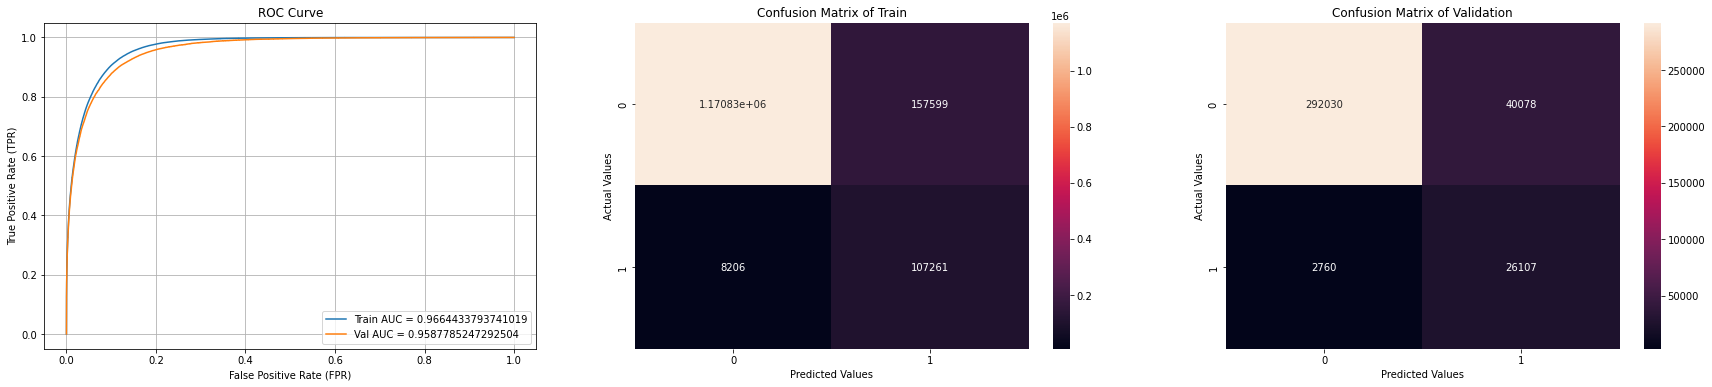

In [38]:
MODEL_NAME = 'Model_3'
plot_roc_confusion(MODEL_NAME)

In [ ]:
#submit and check test GAUC
y_test_pred = model_3.predict(X_test, batch_size=2048, verbose=1)

submission = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/test.csv')
submission = submission.iloc[:,0:1]
submission['prediction'] = y_test_pred
submission.head()

48/48 [==============================] - 8s 162ms/step


,id,prediction
0,7097320,0.002471
1,7097321,0.033996
2,7097322,0.372729
3,7097323,0.000309
4,7097324,0.001427


In [ ]:
submission.to_csv('jigsaw_submit_3.csv', index=False)

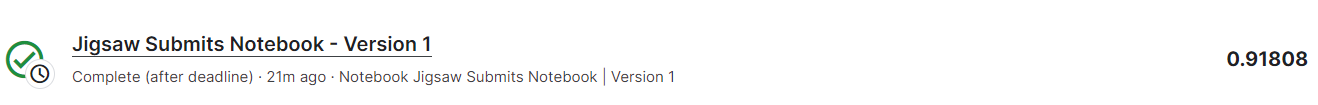

## **3.4 Load Processed Data (No Split)**

### **Padded sequence data (No Split)**

In [41]:
X_train = np.load('/content/gdrive/MyDrive/Jigsaw Files/No Split/X_train_pad.npy')
y_train = np.load('/content/gdrive/MyDrive/Jigsaw Files/No Split/y_train.npy')

X_test = np.load('/content/gdrive/MyDrive/Jigsaw Files/No Split/X_test_pad.npy')

print('Shapes:',X_train.shape, y_train.shape, X_test.shape)

Shapes: (1804874, 105) (1804874,) (97320, 105)


### **Embedding Matrix (No Split)**

In [42]:
embed_mat = np.load('/content/gdrive/MyDrive/Jigsaw Files/No Split/embed_mat.npy')
print('Shape:', embed_mat.shape)
embed_mat[:5]

Shape: (242595, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.04983   ,  0.02705   , -0.38787001, ..., -0.30357999,
         0.27074999,  0.18046001],
       [-0.049291  ,  0.20483001, -0.12808   , ..., -0.28529   ,
         0.33702999,  0.12335   ],
       [-0.14121   ,  0.034641  , -0.44299999, ..., -0.29866001,
         0.013515  ,  0.025409  ],
       [-0.26879001,  0.17483   , -0.35633001, ..., -0.17138   ,
         0.26846001,  0.19866   ]])

### **Toxicity and Identity Data**

In [43]:
toxicity_feat = ['target_cont','severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
identity_main = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',  'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [44]:
toxicity_data = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/toxicity_data.csv')
print("Shape:",toxicity_data.shape)
toxicity_data.head()

Shape: (1804874, 7)


,target_cont,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
4,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0


In [45]:
identity_data = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/identity_data.csv')
identity_data['target'] = identity_data['target_cont'].apply(lambda x: 1 if x>=0.5 else 0).astype(int)
print("Shape:",identity_data.shape)
identity_data.head()

Shape: (1804874, 11)


,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target_cont,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.893617,1


## **3.5 Compute Loss Weight & Sample Weights**


In [46]:
"""
GAUC is a mean of 4 AUCs : Overall, Subgroup, BPSN, BNSP. 
For each sample check if it satisfies the condition to be a part of each of these AUC calculations. 
For each condition satisfied by the sample, add 0.25 to its weight. 
"""
#refer - https://github.com/jiaruxu233/Jigsaw-Unintended-Bias-in-Toxicity-Classification/blob/master/Custom_Loss.ipynb

# Overall
weights = np.ones((len(identity_data),)) / 4

# Subgroup
weights += (identity_data[identity_main].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4

# Background Positive, Subgroup Negative
weights += (( (identity_data['target_cont'].values>=0.5).astype(bool).astype(np.int) +
   (identity_data[identity_main].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1).astype(bool).astype(np.int) / 4

# Background Negative, Subgroup Positive
weights += (( (identity_data['target_cont'].values<0.5).astype(bool).astype(np.int) +
   (identity_data[identity_main].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1).astype(bool).astype(np.int) / 4

loss_weight = 1.0 / weights.mean()
print('Custom Loss Weight:', loss_weight)

y_train = np.hstack([y_train.reshape(-1,1), weights.reshape(-1,1)])
y_aux_train = toxicity_data[toxicity_feat].values

Custom Loss Weight: 3.209226860170181


In [47]:
"""
Use the sample weights to calculate the BCE. 
Note: There is a sample weight parameter in model.fit() but we don't know if it shuffles the weights as it shuffles the samples during train
so for safe side we create an array with y_train values and the sample weights stacked together and define a custom loss which computes Sample Weighted BCE.
"""
#refer - https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/discussion/101690
def custom_loss(y_true, y_pred):
    y_true_labels = tf.reshape(y_true[:,0],shape = (-1,1))
    y_true_weights = y_true[:,1]
    return binary_crossentropy(y_true_labels, y_pred) * y_true_weights

## **3.6 Build and Train Models (Set-2)**

## **Model - 4**
Features:
- BiLSTM(128) and BiGRU(128) layer used
- Attention(128), GlobalAveragePooling1D, GlobalMaxPool1D layers included
- Auxiliary Targets introduced 
- Weighted Loss obtained from Custom BCE with Sample Weighting and Simple BCE Loss 
- Complete Train Data used for training


In [ ]:
#config
SEED = 420
INPUT_LEN = 105 
DROPOUT_RATIO = 0.25
LSTM_UNITS = 128
GRU_UNITS = 128
ATT_UNITS = 128
DENSE_UNITS = 768
NUM_AUX_TARG = len(toxicity_feat)

In [ ]:
#architecture
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.backend.clear_session()

sequences = Input(shape = (INPUT_LEN,))
x = Embedding(input_dim=embed_mat.shape[0], output_dim=embed_mat.shape[1], input_length = INPUT_LEN, weights=[embed_mat], trainable=False)(sequences)
x = SpatialDropout1D(DROPOUT_RATIO)(x)
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
x = Bidirectional(GRU(GRU_UNITS, return_sequences=True))(x)

a,w = AttentionWithContext(units=ATT_UNITS, return_weights=True)(x)
p1 = GlobalAveragePooling1D()(x)
p2 = GlobalMaxPool1D()(x) 

x = Concatenate()([a,p1,p2])
x = Add()([x, Dense(DENSE_UNITS, activation='relu')(x)])
x = Add()([x, Dense(DENSE_UNITS, activation='relu')(x)])

pred = Dense(1, activation = "sigmoid")(x)
aux_preds = Dense(NUM_AUX_TARG, activation='sigmoid')(x) 

model_4 = Model(inputs = sequences, outputs = [pred, aux_preds])
model_4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 105, 300)     72778500    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 105, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 105, 256)     439296      ['spatial_dropout1d[0][0]']  

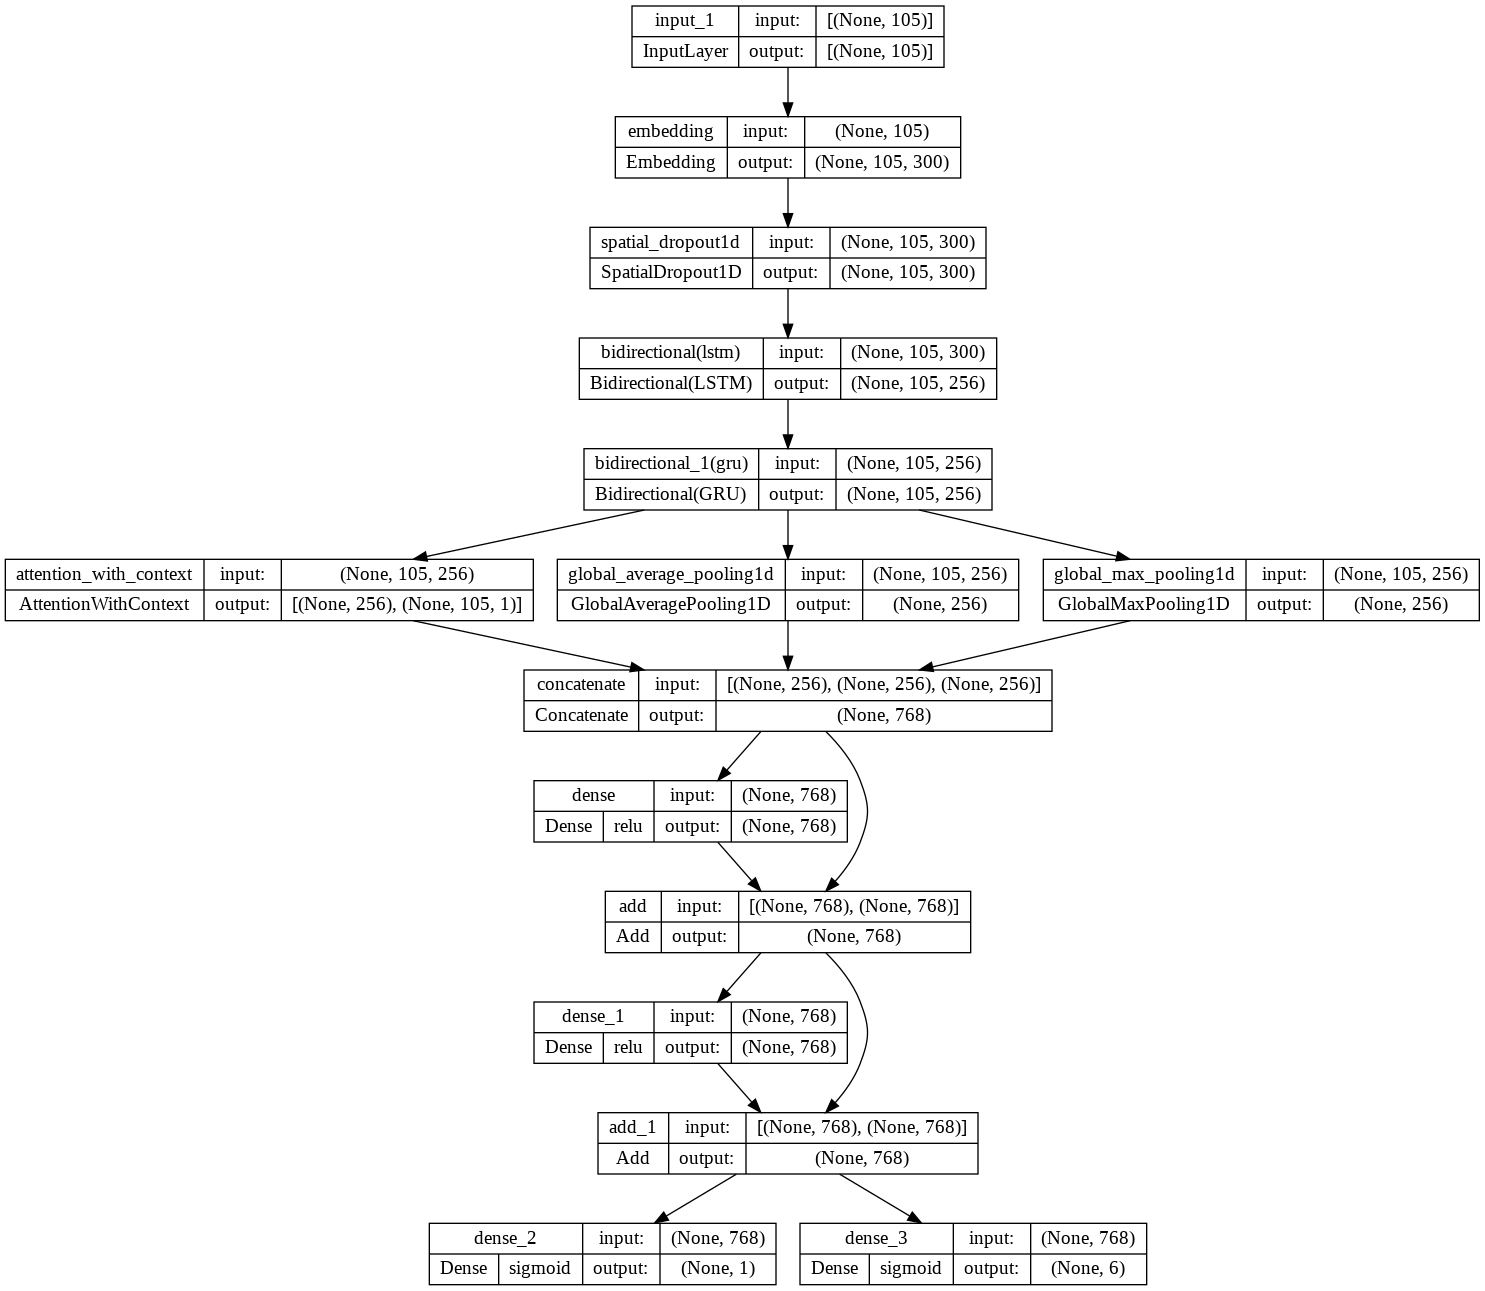

In [ ]:
tf.keras.utils.plot_model(model_4, to_file='/content/gdrive/MyDrive/Jigsaw Files/Model Graphs/model_4.png', show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
earlystop_cb = EarlyStopping(monitor='loss', patience=3, verbose=1, min_delta=0.001, mode='min', restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='loss', patience = 2, factor = 0.5, mode='min', min_delta = 0.0001, min_lr=1e-7)
callbacks = [earlystop_cb, reduce_lr_cb]

In [ ]:
model_4.compile(loss=[custom_loss, 'binary_crossentropy'], loss_weights=[loss_weight, 1.0], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025))
history_4 = model_4.fit(x = X_train, y = [y_train, y_aux_train], batch_size = 2048, epochs = 5, callbacks = callbacks, verbose = 1)

Epoch 1/5
882/882 [==============================] - 398s 439ms/step - loss: 0.3192 - dense_2_loss: 0.0647 - dense_3_loss: 0.1115 - lr: 0.0025
Epoch 2/5
882/882 [==============================] - 386s 438ms/step - loss: 0.2888 - dense_2_loss: 0.0571 - dense_3_loss: 0.1055 - lr: 0.0025
Epoch 3/5
882/882 [==============================] - 387s 438ms/step - loss: 0.2812 - dense_2_loss: 0.0550 - dense_3_loss: 0.1047 - lr: 0.0025
Epoch 4/5
882/882 [==============================] - 386s 438ms/step - loss: 0.2754 - dense_2_loss: 0.0534 - dense_3_loss: 0.1041 - lr: 0.0025
Epoch 5/5
882/882 [==============================] - 386s 438ms/step - loss: 0.2708 - dense_2_loss: 0.0520 - dense_3_loss: 0.1039 - lr: 0.0025


In [48]:
filepath = '/content/gdrive/MyDrive/Jigsaw Files/Models & Weights/model_4'

# save_model(model_4, filepath)
model_4 = load_model(filepath, contain_custom_obj=True)

In [49]:
#check train GAUC
y_train_pred = model_4.predict(X_train, batch_size=2048, verbose=1)
identity_data['Model_4'] = y_train_pred[0]

bias_metrics_train = compute_bias_metrics_for_model(identity_data, identity_main, 'Model_4', 'target')
custom_train = get_final_metric(bias_metrics_train, calculate_overall_auc(identity_data, 'Model_4'))
print('Generalized AUC (Train):', custom_train)

882/882 [==============================] - 132s 149ms/step
Generalized AUC (Train): 0.9410802653697833


In [50]:
bias_metrics_train

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,4997,0.874976,0.896647,0.954780
7,white,13086,0.888916,0.893847,0.962420
6,black,7656,0.889202,0.874759,0.966915
5,muslim,12690,0.897551,0.911388,0.957296
4,jewish,3974,0.920089,0.941298,0.946842
8,psychiatric_or_mental_illness,1256,0.940441,0.929054,0.966490
3,christian,17128,0.948447,0.971318,0.932241
1,female,30189,0.948733,0.960854,0.950671
0,male,19005,0.949258,0.956760,0.955074


Overall AUC (Train): 0.9721840535964712
The maximum value of TPR*(1-FPR) 0.8355985286213811 for threshold 0.166


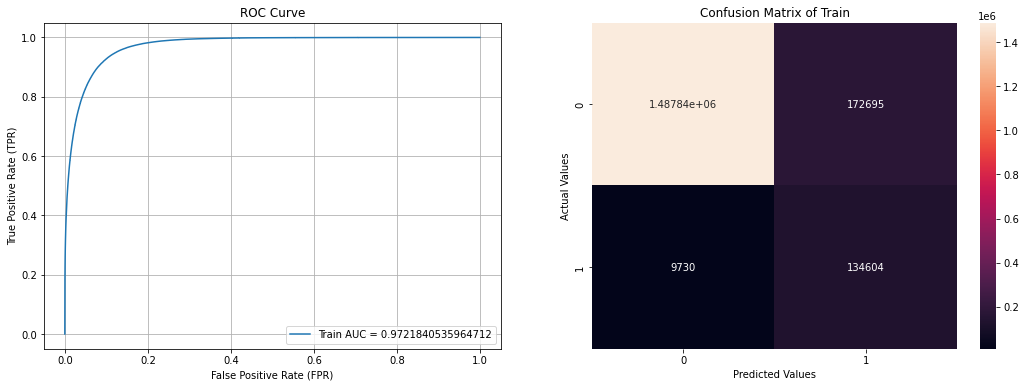

In [60]:
MODEL_NAME = 'Model_4'
plot_roc_confusion_(MODEL_NAME)

In [ ]:
#submit and check test GAUC
y_test_pred = model_4.predict(X_test, batch_size=2048, verbose=1)

submission = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/test.csv')
submission = submission.iloc[:,0:1]
submission['prediction'] = y_test_pred[0]
submission.head()

48/48 [==============================] - 7s 144ms/step


,id,prediction
0,7097320,0.001798
1,7097321,0.022443
2,7097322,0.063930
3,7097323,0.000302
4,7097324,0.000556


In [ ]:
submission.to_csv('jigsaw_submit_4.csv', index=False)

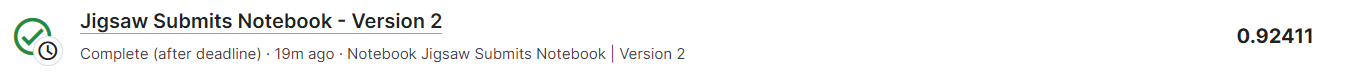

## **Model - 5**
Features:
- BiLSTM(128) and BiGRU(128) layer used
- Attention(128), GlobalAveragePooling1D, GlobalMaxPool1D layers included
- Auxiliary Targets introduced 
- Weighted Loss obtained from Custom BCE with Sample Weighting and Simple BCE Loss 
- Complete Train Data used for training
- Weighted Average of Predictions from single epoch trained model instances

In [ ]:
INPUT_LEN = 105 
DROPOUT_RATIO = 0.25
LSTM_UNITS = 128
GRU_UNITS = 128
ATT_UNITS = 128
DENSE_UNITS = 768
NUM_AUX_TARG = len(toxicity_feat)

def build_model_instance():
    tf.keras.backend.clear_session()

    sequences = Input(shape = (INPUT_LEN,))
    x = Embedding(input_dim=embed_mat.shape[0], output_dim=embed_mat.shape[1], input_length = INPUT_LEN, weights=[embed_mat], trainable=False)(sequences)
    x = SpatialDropout1D(DROPOUT_RATIO)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(GRU(GRU_UNITS, return_sequences=True))(x)

    a,w = AttentionWithContext(units=ATT_UNITS, return_weights=True)(x)
    p1 = GlobalAveragePooling1D()(x)
    p2 = GlobalMaxPool1D()(x) 

    x = Concatenate()([a,p1,p2])
    x = Add()([x, Dense(DENSE_UNITS, activation='relu')(x)])
    x = Add()([x, Dense(DENSE_UNITS, activation='relu')(x)])

    pred = Dense(1, activation = "sigmoid")(x)
    aux_preds = Dense(NUM_AUX_TARG, activation='sigmoid')(x) 

    model = Model(inputs = sequences, outputs = [pred, aux_preds])
    model.compile(loss=[custom_loss, 'binary_crossentropy'], loss_weights=[loss_weight, 1.0], optimizer='adam')
    return model

In [ ]:
#refer - https://www.kaggle.com/code/beautifulsoup4/bilstm-0-6lrsched-identity-customloss
checkpoint_predictions = []
weights = []

for model_idx in range(2):
    model = build_model_instance()
    for global_epoch in range(4):
        model.fit(
            X_train,
            [y_train, y_aux_train],
            batch_size=2048,
            epochs=1,
            verbose=1,
            callbacks=[
                LearningRateScheduler(lambda epoch: 1e-3 * (0.6 ** global_epoch))
            ]
        )
        #save the model
        config = tf.keras.layers.serialize(model)
        pickle.dump(config, open(f'/content/gdrive/MyDrive/Jigsaw Checkpoint Models/config_{model_idx}_{global_epoch}.pkl','wb'))
        model.save_weights(f'/content/gdrive/MyDrive/Jigsaw Checkpoint Models/weights_{model_idx}_{global_epoch}.h5') 

        checkpoint_predictions.append(model.predict(X_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)
    del model
    gc.collect()

48/48 [==============================] - 7s 151ms/step


In [ ]:
predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

submission = pd.read_csv('/content/gdrive/MyDrive/Jigsaw Files/test.csv')
submission = submission.iloc[:,0:1]
submission['prediction'] = predictions
submission.head()

,id,prediction
0,7097320,0.003053
1,7097321,0.037233
2,7097322,0.155518
3,7097323,0.001196
4,7097324,0.001052


In [ ]:
submission.to_csv('jigsaw_submit_5.csv', index=False)

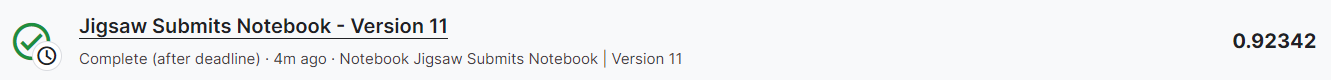

# **4. Summary**

In [5]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Embedding", "Weighting", "Attention", "Loss", "Auxiliary Target", "Train AUC", "Train GAUC", "Val AUC", "Val GAUC", "Test GAUC"]
x.add_rows(
    [
        ["Model-1", "Glove-840B-300D", "Class", "No", "BCE", "No", 0.966, 0.930, 0.958, 0.919, 0.918],
        ["Model-2", "Glove-840B-300D", "Class", "Yes", "BCE", "No", 0.965, 0.928, 0.958, 0.917, 0.916],
        ["Model-3", "Glove-840B-300D", "Class", "Yes", "BCE", "No", 0.966, 0.930, 0.958, 0.918, 0.918],
        ["Model-4", "Glove-840B-300D", "Sample", "Yes", "Weighted Loss", "Yes", 0.972, 0.941, "NA", "NA", 0.924],
        ["Model-5", "Glove-840B-300D", "Sample", "Yes", "Weighted Loss", "Yes", '-', '-', "NA", "NA", 0.923],
        
    ]
)

print(x)

+---------+-----------------+-----------+-----------+---------------+------------------+-----------+------------+---------+----------+-----------+
|  Model  |    Embedding    | Weighting | Attention |      Loss     | Auxiliary Target | Train AUC | Train GAUC | Val AUC | Val GAUC | Test GAUC |
+---------+-----------------+-----------+-----------+---------------+------------------+-----------+------------+---------+----------+-----------+
| Model-1 | Glove-840B-300D |   Class   |     No    |      BCE      |        No        |   0.966   |    0.93    |  0.958  |  0.919   |   0.918   |
| Model-2 | Glove-840B-300D |   Class   |    Yes    |      BCE      |        No        |   0.965   |   0.928    |  0.958  |  0.917   |   0.916   |
| Model-3 | Glove-840B-300D |   Class   |    Yes    |      BCE      |        No        |   0.966   |    0.93    |  0.958  |  0.918   |   0.918   |
| Model-4 | Glove-840B-300D |   Sample  |    Yes    | Weighted Loss |       Yes        |   0.972   |   0.941    |    N

# **5. Conclusion**
- Model-4 performed the best so we proceed to run a performance analysis on few samples in the next notebook to check how well it works against unitended bias (i.e. non-toxic comments mentioning identities) alongside observing the attention weights.
- Implementing Attention, Auxiliary Targets, Custom Loss and whole of Train set for training in Model-4 helps to achieve a high GAUC  of 0.924. We may proceed with building the Final Pipeline using this model.

# **6. References**
- https://tung2389.github.io/coding-note/unitslstm - Explains LSTM 
- https://www.researchgate.net/publication/323130660_Text_Classification_Research_with_Attention-based_Recurrent_Neural_Networks
- https://aclanthology.org/2020.acl-main.312.pdf - Attention in Text Classification
- https://towardsdatascience.com/create-your-own-custom-attention-layer-understand-all-flavours-2201b5e8be9e - Explains how to implement Attention Layer to Classification problem instead of typical seq2seq
- https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/discussion/101690 -Sample Weighted Loss in Keras
- https://github.com/jiaruxu233/Jigsaw-Unintended-Bias-in-Toxicity-Classification/blob/master/Custom_Loss.ipynb -Sample Weights Calculation
- https://www.kaggle.com/code/beautifulsoup4/bilstm-0-6lrsched-identity-customloss - Implementing Weighted Average Checkpoint Predictions
- https://www.researchgate.net/publication/341238064_Avoiding_Unintended_Bias_in_Toxicity_Classification_with_Neural_Networks - Model Architectures
- https://exchange.scale.com/public/blogs/attention-models-what-they-are-and-why-they-matter